In [1]:
%load_ext autoreload
%autoreload 2
import sys
if "../.." not in sys.path:
    sys.path.append("../..")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from signature.signature.tensor_algebra import TensorAlgebra
from signature.signature.tensor_sequence import TensorSequence
from signature.signature.stationary_signature import stationary_signature_from_path, G, discount_ts, strip_bm_path
from signature.signature.expected_signature import expected_signature, expected_stationary_signature
from signature.signature.learning.sig_moment_matching import StatSigSignal

from simulation.diffusion import Diffusion


my_green = "#5b6c64"
my_copper = "#B56246"
plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color=[my_green, my_copper, "#322B4D", "#28BC9C", "#71074E"]) 

In [2]:
N = 8

In [3]:
%%time
ta = TensorAlgebra(dim=2, trunc=N)

Compiling...
Compilation finished.
CPU times: total: 3min 43s
Wall time: 4min 3s


In [73]:
e0 = ta.from_dict({"": 1}, trunc=N)

e1 = ta.from_dict({"1": 1}, trunc=N)
e2 = ta.from_dict({"2": 1}, trunc=N)

e11 = ta.from_dict({"11": 1}, trunc=N)
e12 = ta.from_dict({"12": 1}, trunc=N)
e21 = ta.from_dict({"21": 1}, trunc=N)
e22 = ta.from_dict({"22": 1}, trunc=N)

e112 = ta.from_dict({"112": 1}, trunc=N)
e122 = ta.from_dict({"122": 1}, trunc=N)
e212 = ta.from_dict({"212": 1}, trunc=N)
e222 = ta.from_dict({"222": 1}, trunc=N)

# Standard signatures of the stationary signal

In [74]:
trunc_model = 3
trunc_moments = 4

In [85]:
%%time

T = 500
t_grid = np.linspace(-30, T, 20000 + 1)
t_grid_pos = t_grid[t_grid >= 0]
rng = np.random.default_rng(seed=50)

lam = 15
size = 2

diffusion = Diffusion(t_grid=t_grid - t_grid[0], size=size, rng=rng)
W = diffusion.brownian_motion()[0, 0, :]
path = np.vstack([t_grid, W]).T
SigS = stationary_signature_from_path(path=path, trunc=trunc_model, t_grid=t_grid, lam=lam)

CPU times: total: 625 ms
Wall time: 621 ms


In [86]:
%%time
rng_ = np.random.default_rng(seed=42)
model = StatSigSignal(trunc=trunc_model, lam=lam, t_grid=t_grid_pos, rng=rng_, window_size=30)

Compiling...
Compilation finished.
CPU times: total: 562 ms
Wall time: 628 ms


In [99]:
# ell = e222 * 20 + e2 * 1 + e12 * 5
#ell_old = e1 * (1) + e2 * (-1) + e11 * 6 + e12 * (-2) + e21 * (-6) + e22 * 2
ell = e0 * (6 / lam**2 / 2 + 1 / lam) + e2 * (-1 - 6 / lam) + e12 * 4 + e22 * 2 + e112 * 6 + e122 * (3) + e212 * 10 + e222 * (5)
signal = (ell @ SigS).squeeze().real
signal_with_model_random_numbers = (ell @ model.SigS).squeeze().real

In [100]:
l_coefs = (6 / lam**2 / 2 + 1 / lam), (-1 - 6 / lam), 4, 2

In [101]:
ta.print(ell)

0.08*∅ + -1.4*2 + 4.0*12 + 2.0*22 + 6.0*112 + 3.0*122 + 10.0*212 + 5.0*222


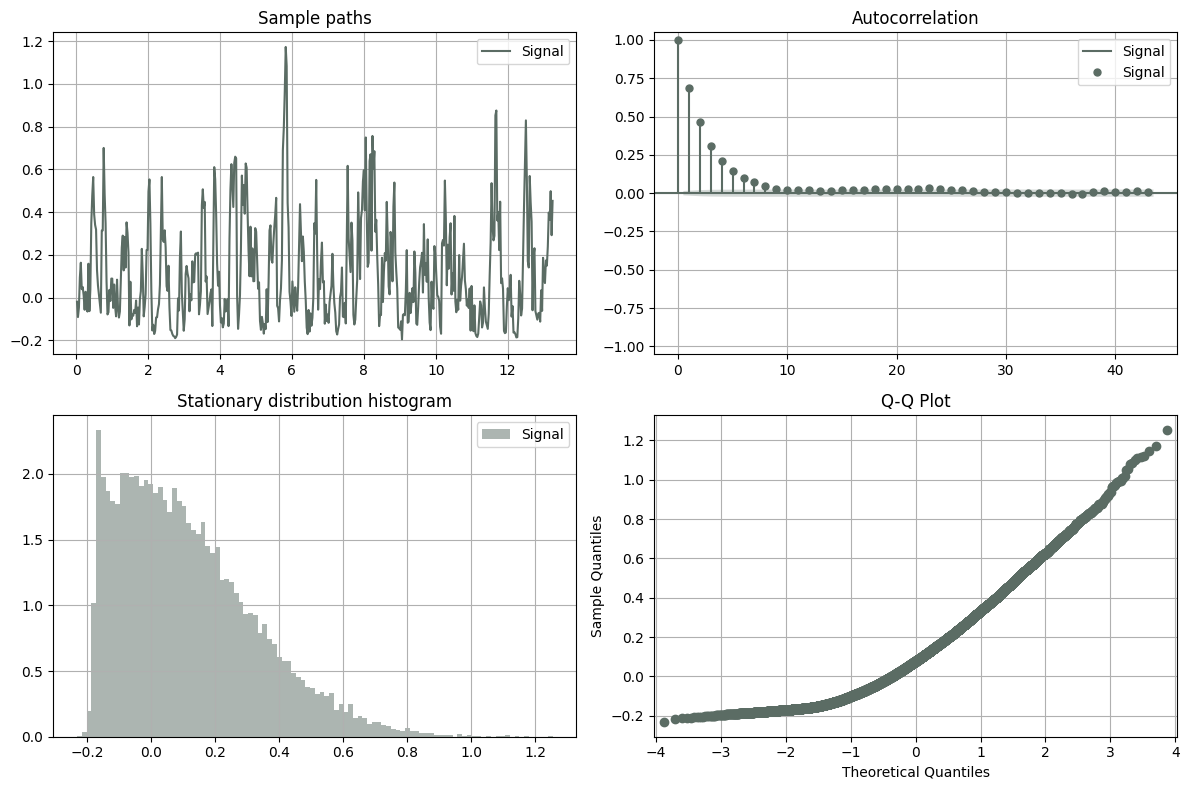

In [102]:
model.analysis(signal_with_model_random_numbers, window_size=500)

In [103]:
def run_calib(weights, optimizer):
    model.loss_weights = weights
    model.optimizer = optimizer
    print(f"Calibrating with weights {model.loss_weights} using the solver {model.optimizer}")
    model.fit(signal)
    print("Calibrated coefficients:")
    ta.print(model.l)
    model.analysis(signal_with_model_random_numbers, window_size=500)

Calibrating with weights (1, 0.0) using the solver BFGS
Esig: 1.2434572593609858, Stationary moments: 0.0
New iteration: 
 x = [ 0.00304718  0.67731842  0.04591003  0.74016325 -0.01804991  0.01205768
  0.01377759 -0.10744374], 
 val=1.2434572593609858. 

Esig: 0.8230100488138608, Stationary moments: 0.0
New iteration: 
 x = [ 0.00304718  0.62288868  0.04304435  0.79451049 -0.01814076  0.01384609
  0.01474522 -0.1024228 ], 
 val=0.8230100488138608. 

Esig: 0.7385710450478347, Stationary moments: 0.0
New iteration: 
 x = [ 0.00304718  0.59395499  0.04585521  0.81180371 -0.01776301  0.01567806
  0.01452076 -0.1718805 ], 
 val=0.7385710450478347. 

Esig: 0.7037177531697635, Stationary moments: 0.0
New iteration: 
 x = [ 0.0030469   0.5586755   0.0541965   0.8144576  -0.01668071  0.02142889
  0.01235852 -0.38381978], 
 val=0.7037177531697635. 

Esig: 0.6424472191142927, Stationary moments: 0.0
New iteration: 
 x = [ 0.00304691  0.50722061  0.06874922  0.80389723 -0.01462834  0.03351394
  0.

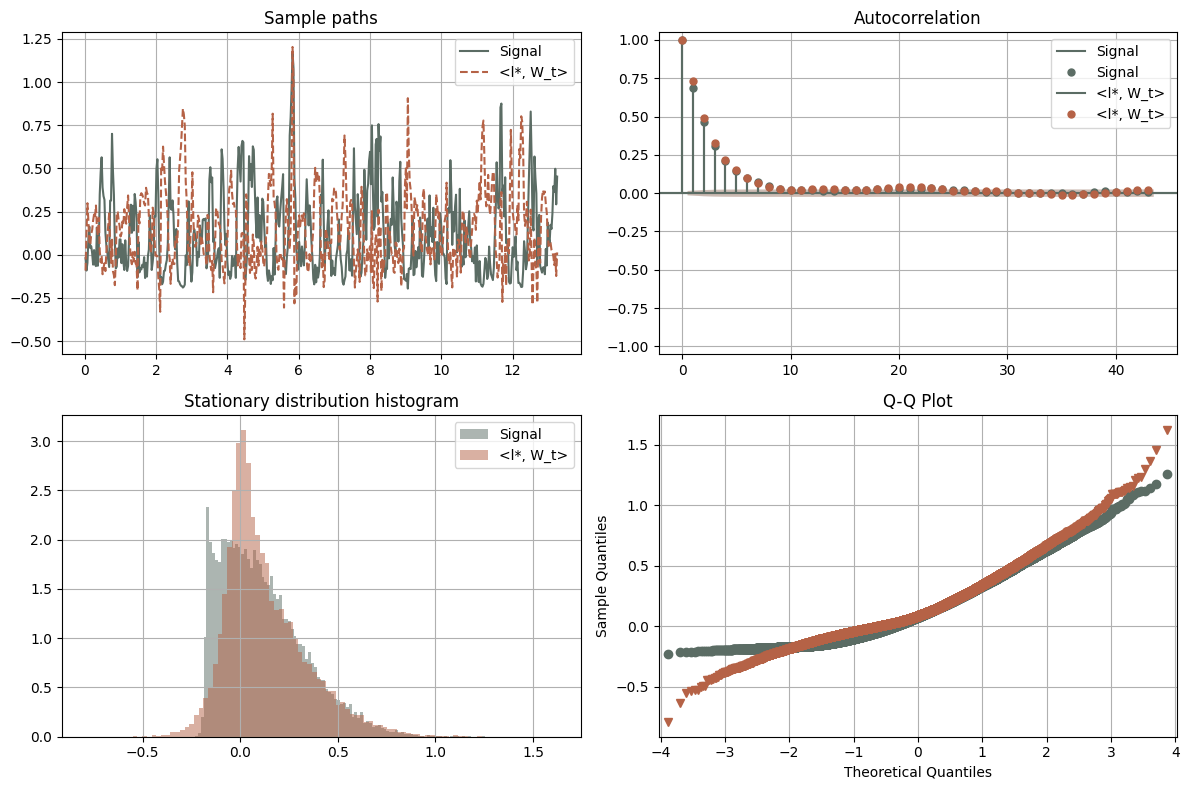

CPU times: total: 30min 34s
Wall time: 32min 15s


In [104]:
%%time
run_calib(weights=(1, 0.0), optimizer="BFGS")

Calibrating with weights (1, 0.0) using the solver Powell
Esig: 0.18686460952392644, Stationary moments: 0.0
New iteration: 
 x = [ 0.00980746 -0.00535917  0.0073747   0.00941743 -0.02886798 -0.01217388
  0.00114416 -0.00260316], 
 val=0.18686460952392644. 

Esig: 0.1787065014397965, Stationary moments: 0.0
New iteration: 
 x = [ 1.04243197 -0.00532848  0.00728305  0.00942771 -0.03713541 -0.01142796
  0.00105117 -0.00211658], 
 val=0.1787065014397965. 

Esig: 0.14572000592250883, Stationary moments: 0.0
New iteration: 
 x = [ 9.08342578e+00 -5.09123400e-03  6.52288281e-03  9.51028310e-03
 -1.03118667e-01 -5.52484276e-03  5.57705093e-04  1.75005452e-03], 
 val=0.14572000592250883. 

Esig: 0.14557092030063545, Stationary moments: 0.0
New iteration: 
 x = [ 9.05954165e+00 -5.09194381e-03  6.47100052e-03  9.51297758e-03
 -1.04955507e-01 -5.40665908e-03  7.87986935e-04  1.74736769e-03], 
 val=0.14557092030063545. 

Esig: 0.13434433164119922, Stationary moments: 0.0
New iteration: 
 x = [ 8.

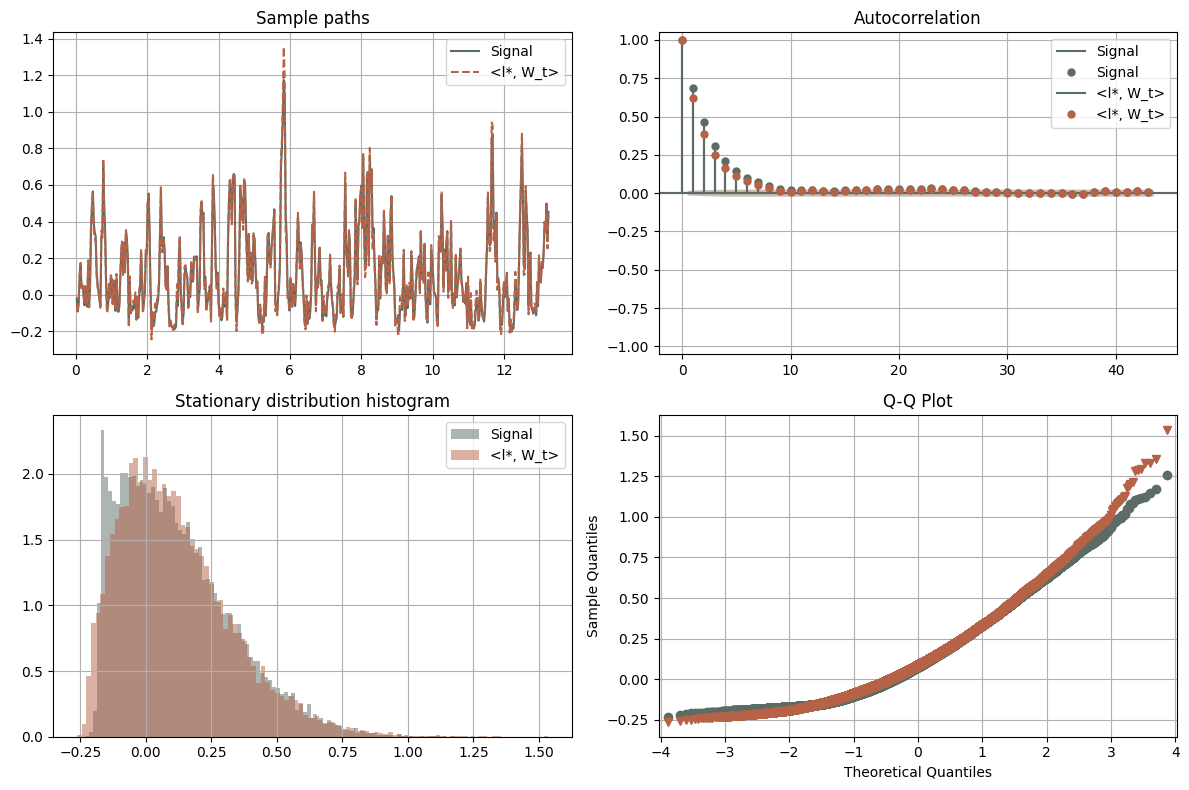

CPU times: total: 16min 11s
Wall time: 17min 7s


In [105]:
%%time
run_calib(weights=(1, 0.0), optimizer="Powell")

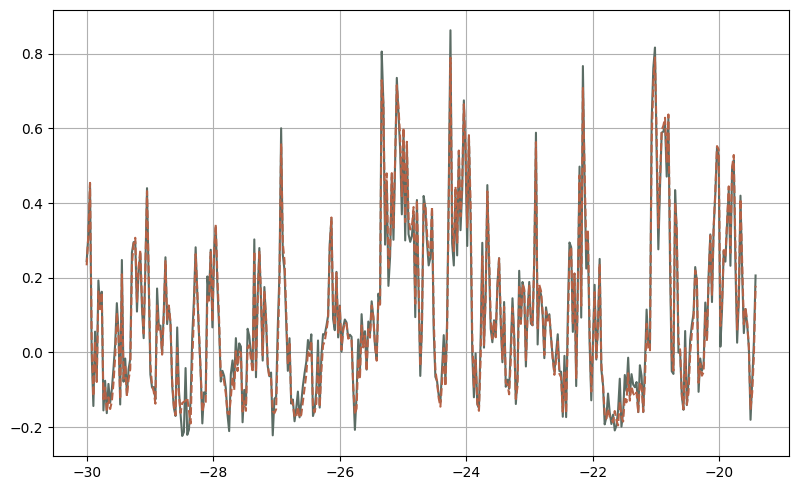

In [109]:
n_show = 400

signal_learnt = (model.l @ SigS).squeeze().real
plt.plot(t_grid[:n_show], signal_learnt[:n_show])
plt.plot(t_grid[:n_show], signal[:n_show], "--")

In [108]:
ta.print(ell)

0.08*∅ + -1.4*2 + 4.0*12 + 2.0*22 + 6.0*112 + 3.0*122 + 10.0*212 + 5.0*222


$0.08279806755071747*∅ + -0.99311116068877*2 + -1.0396880734344074*12 + 1.8785188822194647*22 + -94.9238552617246*112 + 3.8421397610372106*122 + 10.288175070416635*212 + -0.32715551466151443*222$


#### Strip the BM

In [61]:
%%time
W_strip = strip_bm_path(signal=signal, t_grid=t_grid_pos, ts=ell, trunc=2, lam=lam)

100%|█████████████████████████████████████████████████████████████| 5000/5000 [00:11<00:00, 428.52it/s]

CPU times: total: 6.88 s
Wall time: 11.7 s


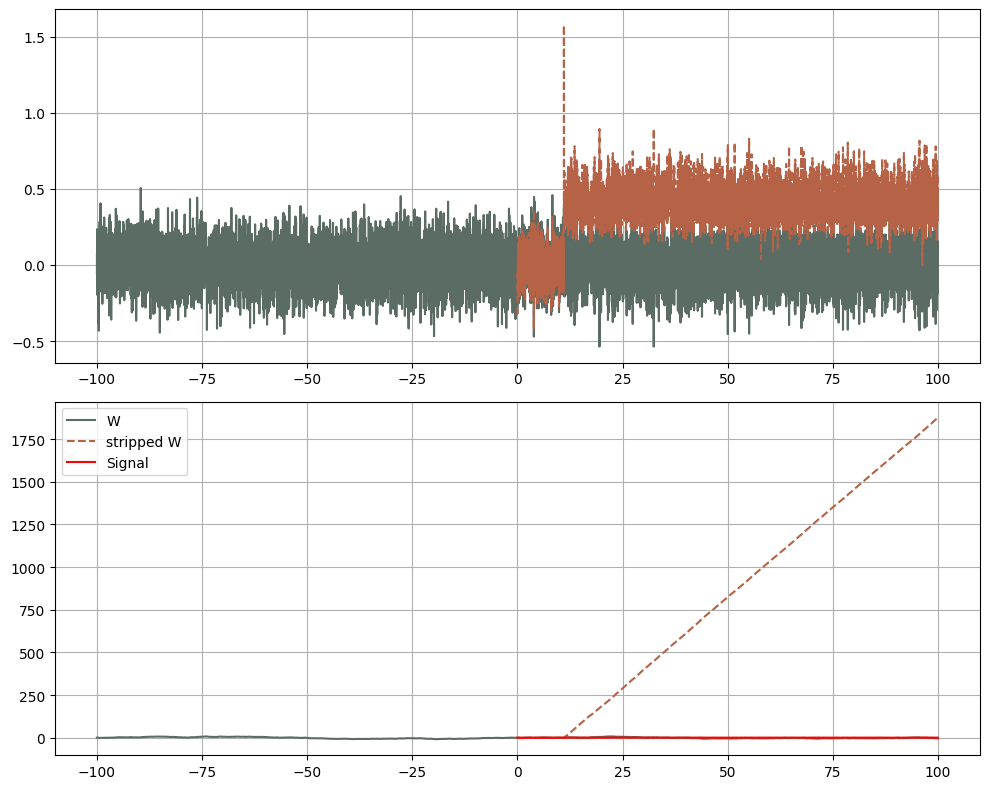

In [62]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(t_grid[1:], np.diff(W))
ax[0].plot(t_grid_pos[1:], np.diff(W_strip), "--")

ax[1].plot(t_grid, W, label="W")
ax[1].plot(t_grid_pos, W_strip - W_strip[0] + W[np.where(t_grid >= 0)[0][0]], "--", label="stripped W")

ax[1].plot(t_grid_pos, signal, 'r', label="Signal")

plt.legend()

# Standard Signatures

In [125]:
T = 0.5
t_grid = np.linspace(-T, T, 200 + 1)
rng = np.random.default_rng(seed=50)

lam = 10
size = 10

In [126]:
%%time
t_grid_pos = t_grid[t_grid >= 0]

diffusion = Diffusion(t_grid=t_grid_pos, size=size, rng=rng)

path_pos = np.empty((len(t_grid_pos), 2, size))
path_pos[:, 0, :] = np.tile(t_grid_pos[:, None], size)
path_pos[:, 1, :] = diffusion.brownian_motion()[:, 0, :].T

Sig = ta.path_to_sequence(path=path_pos, trunc=N)

CPU times: total: 0 ns
Wall time: 12 ms


In [234]:
ell = e1 * (1) + e2 * (-1) + e11 * 6 + e12 * (-2) + e21 * (-6) + e22 * 2
# ell = e22 + e21 + e12
ell_Sig = (ell @ Sig)

C:\Users\DM6579\Anaconda3\envs\signature\lib\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


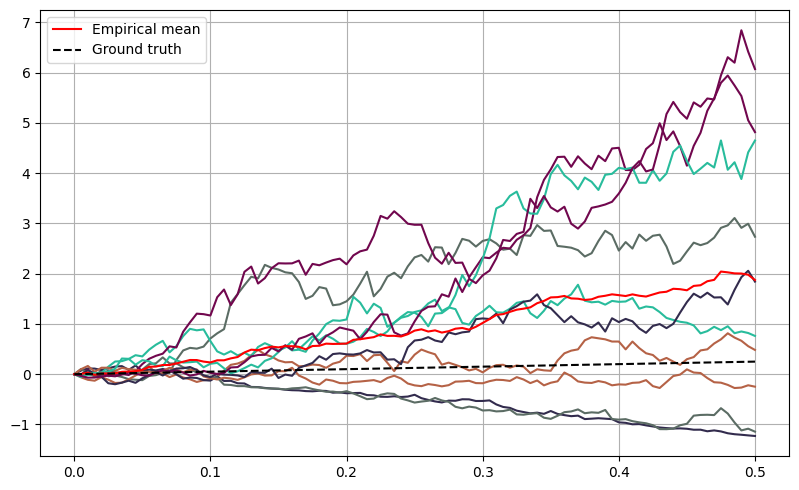

In [235]:
for i in range(10):
    plt.plot(t_grid_pos, ell_Sig[:, i])

plt.plot(t_grid_pos, ell_Sig.mean(axis=1), "r", label="Empirical mean")
plt.plot(t_grid_pos, t_grid_pos / 2, "k--", label="Ground truth")
plt.legend()

#### Calculating the signature of signal

In [236]:
%%time
signal = ell_Sig.real

path_signal = np.empty((len(t_grid_pos), 2, size))
path_signal[:, 0, :] = np.tile(t_grid_pos[:, None], size)
path_signal[:, 1, :] = signal

SignalSig = ta.path_to_sequence(path=path_signal, trunc=N)

CPU times: total: 0 ns
Wall time: 22.3 ms


In [237]:
trunc_moments = 4
n_moments = ta.alphabet.number_of_elements(trunc_moments)
words = [ta.alphabet.index_to_word(idx) for idx in range(n_moments)]

n_moments, words

(31,
 ['∅',
  '1',
  '2',
  '11',
  '12',
  '21',
  '22',
  '111',
  '112',
  '121',
  '122',
  '211',
  '212',
  '221',
  '222',
  '1111',
  '1112',
  '1121',
  '1122',
  '1211',
  '1212',
  '1221',
  '1222',
  '2111',
  '2112',
  '2121',
  '2122',
  '2211',
  '2212',
  '2221',
  '2222'])

In [238]:
def signal_signature_coefs_as_bm_signature_coefs(ts, trunc_moments):
    signal_sig_coefs_exact = dict()
    n_moments = ta.alphabet.number_of_elements(trunc_moments)

    for idx in range(n_moments):
        word = ta.alphabet.index_to_word(idx)
        if not idx:
            signal_sig_coefs_exact[""] = TensorSequence.unit(ta.alphabet, N)
        else:
            if word.endswith("1"):
                signal_sig_coefs_exact[word] = signal_sig_coefs_exact[word[:-1]].tensor_prod_word("1")
            elif word.endswith("2"):
                signal_sig_coefs_exact[word] = ta.shuop.shuffle_prod(signal_sig_coefs_exact[word[:-1]], ts.proj("1")).tensor_prod_word("1") + \
                                               ta.shuop.shuffle_prod(signal_sig_coefs_exact[word[:-1]], ts.proj("2")).tensor_prod_word("2")
    return signal_sig_coefs_exact

In [239]:
%%time
signal_sig_coefs_exact = signal_signature_coefs_as_bm_signature_coefs(ell, trunc_moments)

CPU times: total: 15.6 ms
Wall time: 3 ms


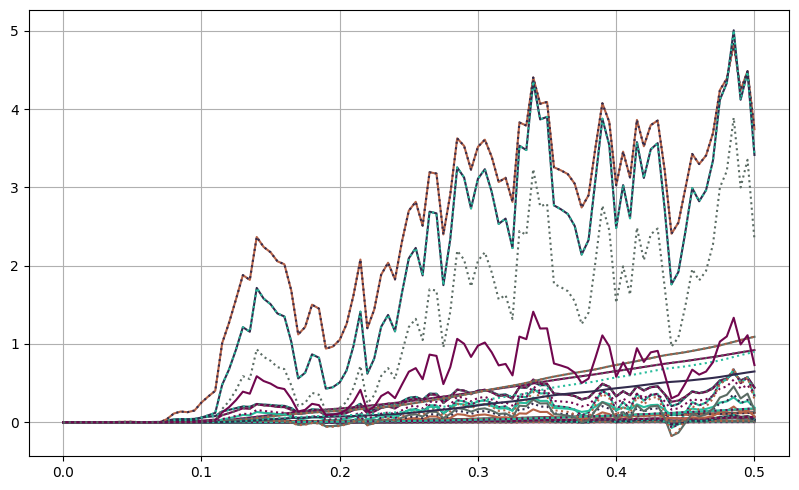

In [240]:
for word in words:
    if len(word) < 2:
        continue
    plt.plot(t_grid_pos, (signal_sig_coefs_exact[word] @ Sig)[:, 0])
    plt.plot(t_grid_pos, (ta.from_dict({word: 1}, trunc=8) @ SignalSig)[:, 0], ":")

In [241]:
%%time
eSig = expected_signature(t=t_grid_pos, trunc=N)

CPU times: total: 62.5 ms
Wall time: 63.6 ms


In [242]:
%%time

expected_signal_sig_estimator = dict()
expected_signal_sig_exact = dict()

for idx in range(n_moments):
    word = ta.alphabet.index_to_word(idx)
    if word == "∅":
        word = ""
    expected_signal_sig_estimator[word] = SignalSig.array[idx].mean(axis=1)
    expected_signal_sig_exact[word] = (signal_sig_coefs_exact[word] @ eSig).squeeze()

CPU times: total: 0 ns
Wall time: 7.89 ms


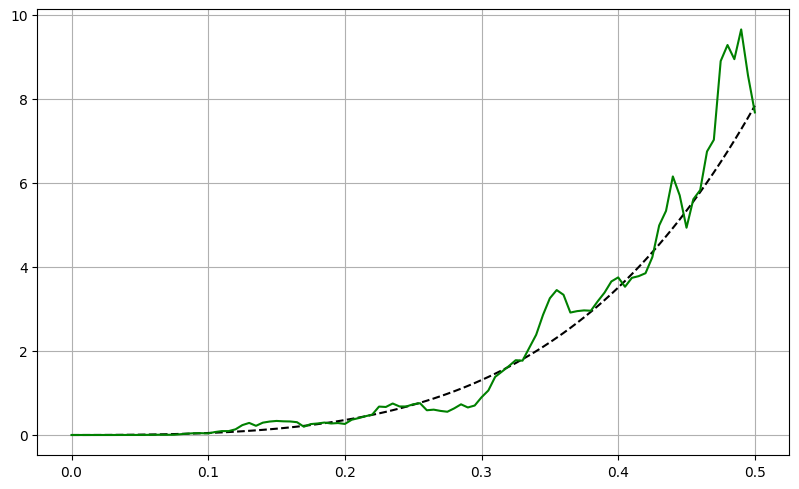

In [243]:
w = "222"
plt.plot(t_grid_pos, expected_signal_sig_exact[w], "k--")
plt.plot(t_grid_pos, expected_signal_sig_estimator[w], "g")

##### Loss functional for a given $l$

In [244]:
from math import factorial

In [245]:
ell_trunc = 2

def loss(x):    
    l = ta.from_array(N, x)
    signal_sig_coefs = signal_signature_coefs_as_bm_signature_coefs(l, trunc_moments)
    
    loss = 0
    for word in words:
        if "2" in word:
            # Moments are supposed to be known exactly
            loss_word = np.sqrt(np.mean(np.abs((signal_sig_coefs[word] @ eSig).squeeze() - expected_signal_sig_exact[word])**2))
            #loss_word = (np.mean(np.abs((signal_sig_coefs[word] @ eSig).squeeze() - expected_signal_sig_exact[word])))
            loss += loss_word * factorial(len(word))
            #print(word, loss_word * factorial(len(word)))
    
    # loss += np.sum(np.abs(x)) * 0.001
    return loss

In [246]:
x0 = np.zeros(ta.alphabet.number_of_elements(ell_trunc))

In [247]:
%%time
loss(x0)

CPU times: total: 15.6 ms
Wall time: 6 ms


80.2950894287626

In [248]:
%%time

from scipy.optimize import minimize

def callback(x, f=None, context=None, accept=None, convergence=None):
    val = loss(x)
    print(f"New iteration: \n x = {x}, \n val={val}. \n")

res = minimize(loss, x0, callback=callback, method="BFGS")
print(res)

New iteration: 
 x = [0.         4.52020777 0.         0.94030114 0.         0.
 2.26010389], 
 val=13.644264750200419. 

New iteration: 
 x = [0.         4.52112402 0.         0.94049837 0.         0.
 2.26107229], 
 val=13.643720835004116. 

New iteration: 
 x = [0.00000000e+00 3.75908545e+00 1.00917067e-07 8.23636661e-01
 0.00000000e+00 0.00000000e+00 3.42946470e+00], 
 val=10.2507051639891. 

New iteration: 
 x = [0.00000000e+00 3.63714202e+00 9.40998629e-07 7.41690842e-01
 7.22675140e-08 4.33605084e-08 3.63768766e+00], 
 val=9.901340876916763. 

New iteration: 
 x = [0.00000000e+00 3.64652210e+00 6.65387773e-05 9.62233650e-02
 6.92422705e-06 6.57953941e-06 3.80813654e+00], 
 val=9.41057709857036. 

New iteration: 
 x = [ 0.00000000e+00  3.69633317e+00  1.00353096e-03 -2.51125297e-01
  9.16808931e-05  7.96929950e-05  3.82797686e+00], 
 val=9.233643495357008. 

New iteration: 
 x = [ 0.00000000e+00  3.74608157e+00  1.99224793e-02 -7.38964648e-01
  7.59161924e-04  7.62081649e-05  3.8

In [249]:
x_opt = res.x
x_opt[0] = ell[""][0, 0].real

In [250]:
ta.print(ell)

1.0*1 + -1.0*2 + 6.0*11 + -2.0*12 + -6.0*21 + 2.0*22


In [251]:
l_opt = ta.from_array(trunc_moments, res.x)
ta.print(l_opt)

0.9999916290289019*1 + -1.0000031054240726*2 + 6.000042063557328*11 + -1.999993636542069*12 + -6.0000011251514564*21 + 1.9999961740526768*22


In [252]:
l_Sig = l_opt @ Sig

C:\Users\DM6579\Anaconda3\envs\signature\lib\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


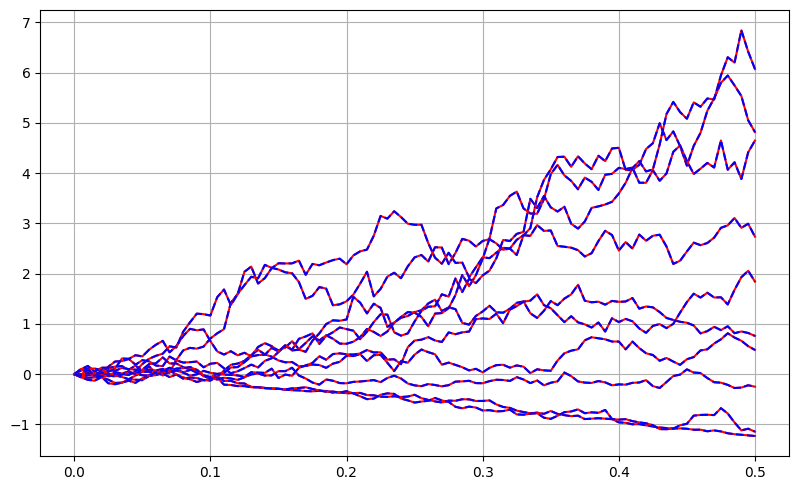

In [253]:
for i in range(10):
    plt.plot(t_grid_pos, ell_Sig[:, i], "r")
    plt.plot(t_grid_pos, l_Sig[:, i], "b--")

## Stationary Signature of signal (does not work properly)

In [150]:
T = 50
t_grid = np.linspace(-T, T, 10000 + 1)
t_grid_pos = t_grid[t_grid >= 0]
rng = np.random.default_rng(seed=50)

lam = 3
size = 2

In [151]:
%%time
diffusion = Diffusion(t_grid=t_grid - t_grid[0], size=size, rng=rng)
W = diffusion.brownian_motion()[0, 0, :]
path = np.vstack([t_grid, W]).T
SigS = stationary_signature_from_path(path=path, trunc=N, t_grid=t_grid, lam=lam)

W2 = diffusion.brownian_motion()[1, 0, :]
path2 = np.vstack([t_grid, W2]).T
SigS_test = stationary_signature_from_path(path=path2, trunc=trunc_moments, t_grid=t_grid, lam=lam)

CPU times: total: 29 s
Wall time: 31.2 s


In [298]:
ell = e2 + e22 * 2
ell_SigS = (ell @ SigS).squeeze().real
ell_SigS_test = (ell @ SigS_test).squeeze().real

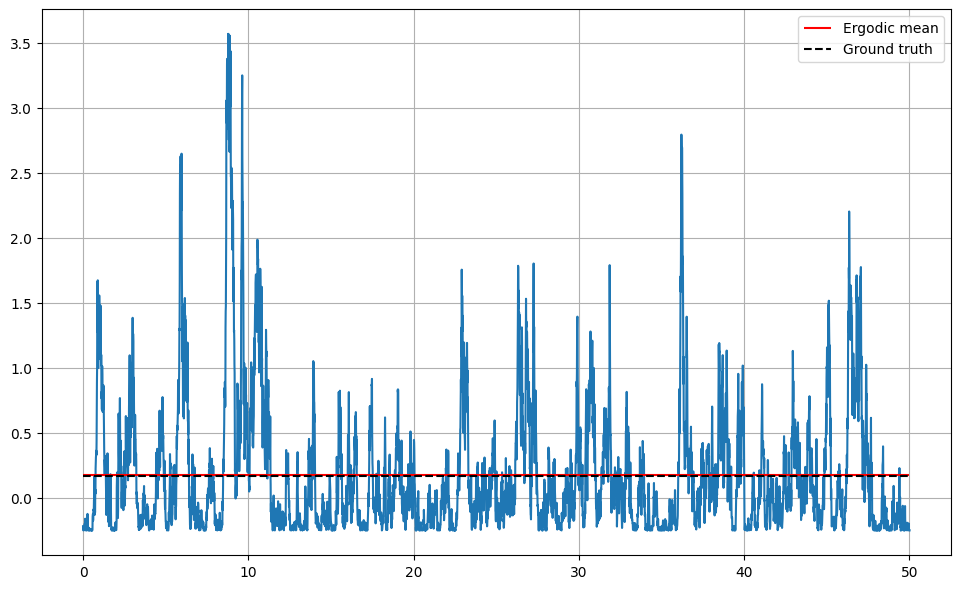

In [301]:
plt.plot(t_grid_pos, ell_SigS)

plt.hlines(ell_SigS.mean(), t_grid_pos[0], t_grid_pos[-1], "r", label="Ergodic mean")
plt.hlines(1 / 2 / lam, t_grid_pos[0], t_grid_pos[-1], "k", linestyles="--", label="Ground truth")

plt.legend()

#### Calculating the signature of signal

In [14]:
%%time
signal = ell_SigS.real

path_signal = np.empty((len(t_grid_pos), 2))
path_signal[:, 0] = t_grid_pos
path_signal[:, 1] = signal

SignalSigS = stationary_signature_from_path(path=path_signal, trunc=N, t_grid=t_grid_pos - 15, lam=lam)

t_grid_s = t_grid_pos[t_grid_pos >= 15]

CPU times: total: 11.4 s
Wall time: 12 s


In [91]:
trunc_moments = 3
n_moments = ta.alphabet.number_of_elements(trunc_moments)
words = [ta.alphabet.index_to_word(idx) for idx in range(n_moments)]

n_moments

15

In [21]:
def resolvent(mu, lam, ts):
    tmp = ts * 1
    res = ts * 1
    for i in range(N):
        tmp.update(G(tmp) * lam - tmp * mu)
        tmp.update(tmp.tensor_prod_word("1"))
        res.update(res + tmp)

    return res

In [22]:
def signal_stat_signature_coefs_as_bm_stat_signature_coefs(ts, trunc_moments):
    signal_sig_coefs_exact = dict()
    n_moments = ta.alphabet.number_of_elements(trunc_moments)

    for idx in range(n_moments):
        word = ta.alphabet.index_to_word(idx)
        if not idx:
            signal_sig_coefs_exact[""] = TensorSequence.unit(ta.alphabet, N)
        else:
            if word.endswith("1"):
                signal_sig_coefs_exact[word] = resolvent(mu=len(word) * lam, lam=lam, ts=signal_sig_coefs_exact[word[:-1]].tensor_prod_word("1"))
            elif word.endswith("2"):
                coef_prev = signal_sig_coefs_exact[word[:-1]]
                c = (ta.shuop.shuffle_prod(coef_prev, ts.proj("1") - G(ts) * lam) - ta.shuop.shuffle_prod(coef_prev.proj("2") / 2, ts.proj("2"))).tensor_prod_word("1") + \
                    ta.shuop.shuffle_prod(coef_prev, ts.proj("2")).tensor_prod_word("2")
                signal_sig_coefs_exact[word] = resolvent(mu=len(word) * lam, lam=lam, ts=c)
    return signal_sig_coefs_exact

In [23]:
%%time
signal_stat_sig_coefs_exact = signal_stat_signature_coefs_as_bm_stat_signature_coefs(ell, trunc_moments)

CPU times: total: 5.41 s
Wall time: 6.2 s


In [24]:
ta.print(signal_stat_sig_coefs_exact["222"])

-1.0*22122 + -3.0*22212 + -6.0*22221 + -3.0*221122 + -3.0*221212 + 3.0*221221 + -9.0*222112 + 9.0*222121 + 18.0*222211 + 15.0*222222 + -18.0*2211122 + -18.0*2211212 + 9.0*2211221 + -18.0*2212112 + 9.0*2212121 + 63.0*2212211 + -9.0*2212222 + -54.0*2221112 + 27.0*2221121 + 189.0*2221211 + -27.0*2221222 + 378.0*2222111 + -54.0*2222122 + -90.0*2222212 + -135.0*2222221 + -162.0*22111122 + -162.0*22111212 + 54.0*22111221 + -162.0*22112112 + 54.0*22112121 + 378.0*22112211 + -54.0*22112222 + -162.0*22121112 + 54.0*22121121 + 378.0*22121211 + -54.0*22121222 + 1026.0*22122111 + -45.0*22122122 + -27.0*22122212 + -486.0*22211112 + 162.0*22211121 + 1134.0*22211211 + -162.0*22211222 + 3078.0*22212111 + -135.0*22212122 + -81.0*22212212 + 6156.0*22221111 + -270.0*22221122 + -162.0*22221212 + -270.0*22222112 + -1944.0*221111122 + -1944.0*221111212 + 486.0*221111221 + -1944.0*221112112 + 486.0*221112121 + 3726.0*221112211 + -486.0*221112222 + -1944.0*221121112 + 486.0*221121121 + 3726.0*221121211 + -486

In [25]:
SigS.array.shape

(1023, 5001, 1)

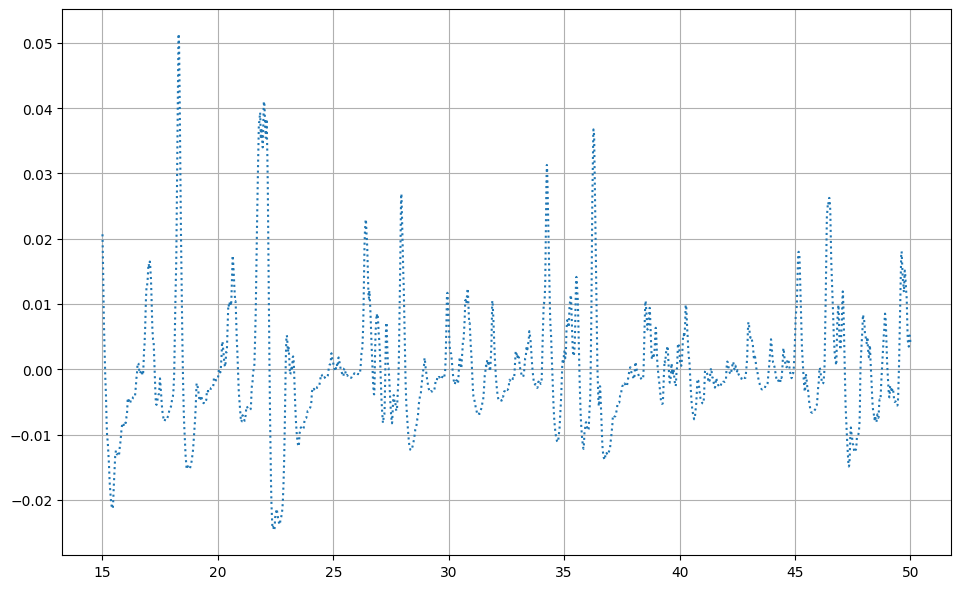

In [30]:
# plt.plot(t_grid_s, (signal_stat_sig_coefs_exact["222"] @ SigS).squeeze()[t_grid_pos >= 15])
plt.plot(t_grid_s, (e21 @ SignalSigS), ":")

In [31]:
%%time
eSigS = expected_stationary_signature(lam=lam, trunc=N)

CPU times: total: 5.41 s
Wall time: 8.23 s


In [281]:
%%time

expected_signal_stat_sig_estimator = dict()
expected_signal_stat_sig_exact = dict()

for idx in range(n_moments):
    word = ta.alphabet.index_to_word(idx)
    if word == "∅":
        word = ""
    expected_signal_stat_sig_estimator[word] = SignalSigS.array[idx].mean()
    expected_signal_stat_sig_exact[word] = (signal_stat_sig_coefs_exact[word] @ eSigS).squeeze()

CPU times: total: 0 ns
Wall time: 0 ns


In [283]:
w = "2"
expected_signal_stat_sig_estimator[w], expected_signal_stat_sig_exact[w]

((1.4819416621710028e-05+0j), array(0.00833333+0.j))

##### Loss functional for a given $l$

In [289]:
ell_trunc = 3

def loss_stat(x):    
    l = ta.from_array(N, x)
    signal_stat_sig_coefs = signal_stat_signature_coefs_as_bm_stat_signature_coefs(l, trunc_moments)
    
    loss = 0
    for word in words:
        if "2" in word:
            # Moments are supposed to be known exactly
            loss_word = np.sqrt(np.mean(np.abs((signal_stat_sig_coefs[word] @ eSigS).squeeze() - expected_signal_stat_sig_exact[word])**2))
            loss += loss_word
    
    return loss

In [290]:
x0 = np.zeros(ta.alphabet.number_of_elements(ell_trunc))

In [291]:
%%time
loss_stat(x0)

CPU times: total: 46.9 ms
Wall time: 94.2 ms


0.010321093750000001

In [293]:
%%time

from scipy.optimize import minimize

def callback(x, f=None, context=None, accept=None, convergence=None):
    val = loss_stat(x)
    print(f"New iteration: \n x = {x}, \n val={val}. \n")

res = minimize(loss_stat, x0, callback=callback, method="BFGS")
print(res)

New iteration: 
 x = [ 0.00000000e+00  3.02261860e-01 -3.10481573e-09  3.02261868e-02
  0.00000000e+00  0.00000000e+00  1.25294210e-01  1.51130787e-03
  0.00000000e+00  0.00000000e+00  1.25294218e-02  0.00000000e+00
  0.00000000e+00  6.26471089e-03  0.00000000e+00], 
 val=0.0022176860482609755. 

New iteration: 
 x = [ 0.00000000e+00  3.51610595e-01 -3.54563448e-09  3.51757401e-02
  0.00000000e+00  0.00000000e+00  1.45847824e-01  1.75944838e-03
  0.00000000e+00  0.00000000e+00  1.45880485e-02  0.00000000e+00
  1.26712280e-06  7.29250426e-03  0.00000000e+00], 
 val=0.0011075077325957319. 

New iteration: 
 x = [ 0.00000000e+00  3.51610598e-01 -3.54563451e-09  3.51757406e-02
 -5.11220152e-18  0.00000000e+00  1.45847825e-01  1.75944840e-03
  0.00000000e+00  0.00000000e+00  1.45880487e-02  0.00000000e+00
  1.26712333e-06  7.29250436e-03 -1.70406717e-18], 
 val=0.0011075076513443784. 

New iteration: 
 x = [ 0.00000000e+00  3.51610598e-01 -3.54563442e-09  3.51757427e-02
 -1.42969984e-17  0.

In [295]:
l_opt = ta.from_array(moments_trunc, res.x)
ta.print(l_opt)

0.3516105983634915*1 + 0.03517576155534584*11 + 0.14584783466533074*22 + 0.0017595189129007553*111 + 0.014588074290246009*122 + 1.28419076285507e-06*212 + 0.007292498171109511*221


In [298]:
l_SigS = l_opt @ SigS

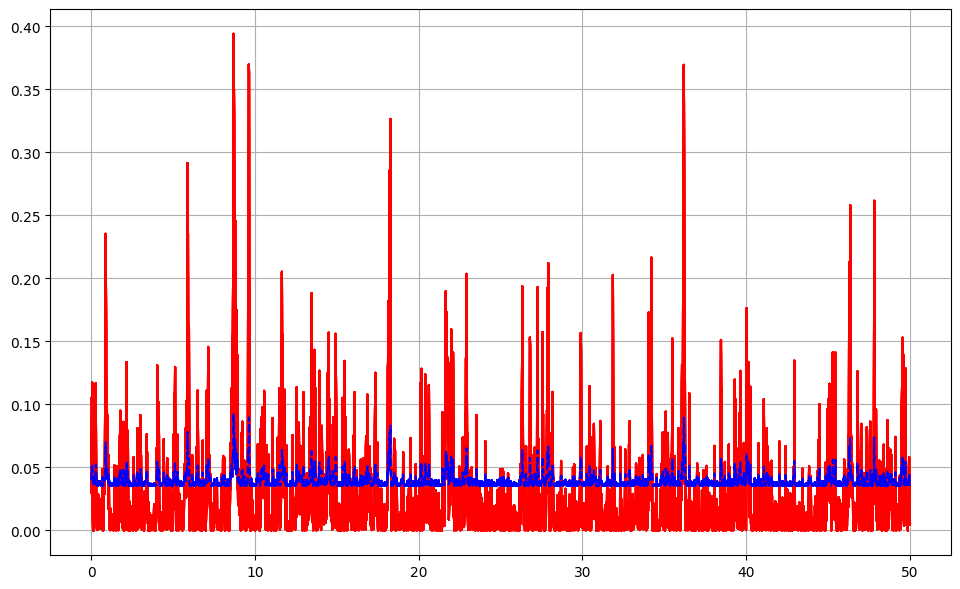

In [299]:
for i in range(10):
    plt.plot(t_grid_pos, ell_SigS, "r")
    plt.plot(t_grid_pos, l_SigS, "b--")